In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 15:21:41 2018

@author: james.macdonald
"""

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import datetime as dt
import random, subprocess, os
from scipy.io import loadmat

tf.__version__

/home/james/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.8.0'

In [2]:
def download_dataset(url):
    fname = url.split("/")[-1]
    if fname not in os.listdir('./'):
        cmd = 'wget '+url
        subprocess.call(cmd, shell=True)
    return fname
    
train = download_dataset('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
test = download_dataset('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')
extra = download_dataset('http://ufldl.stanford.edu/housenumbers/extra_32x32.mat')

def to_greyscale(data, scaling="human"):
    if scaling=="human":
        to_scale = np.array([0.299, 0.587, 0.114])
    elif scaling=="balanced":
        to_scale = np.array([0.3333, 0.3333, 0.3333])
    else:
        raise ValueError("Please select either 'human' or 'balanced' greyscaling")
    return np.dot(data, to_scale)

In [3]:
def get_dataset(location, greyscale="balanced"):
    loaded = loadmat(location)
    if greyscale != "none":
        images = to_greyscale(np.array([loaded['X'][:,:,:,i] for i in range(loaded['X'].shape[3])]), scaling=greyscale)
    else:
        images = np.array([loaded['X'][:,:,:,i] for i in range(loaded['X'].shape[3])])
    cls = np.array(loaded['y'][:,0])
    cls[cls==10] = 0
    labels = np.zeros([len(cls),10])
    labels[range(len(labels)),cls] = 1
    return images, labels, cls

In [4]:
X, y, yclass = get_dataset(train)
Xtest, ytest, ytestclass = get_dataset(test)

In [5]:
def plot_images(images, labels, img_shape=None, cls_pred=None):
    fig, axes = plt.subplots(3, 5)

    for ix, ax in enumerate(axes.flat):
        ax.imshow(images[ix])
        xlabel = "True: {0}".format(labels[ix])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

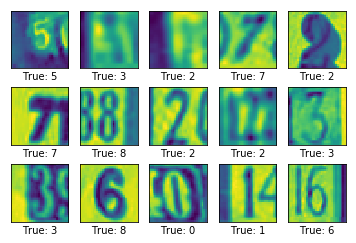

In [6]:
img_dims = 32
#num_channels = 1
num_classes = 10
batch_size = 250
train_batch_size = batch_size

img_shape = (img_dims, img_dims)
img_dims_flat = img_shape[0] * img_shape[1] #* img_shape[2]

np.random.seed(4)
ix = np.random.choice(range(len(X)), replace=False, size=15)
images = X[ix]
labels = yclass[ix]

plot_images(images=images, labels=labels)

In [7]:
# Set parameters for CNN layers

convolution_params = {
    'layer_1':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_2':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':16},
    'layer_3':{'fSize':5, 'fN':64, 'sSize':1, 'activation':'relu', 'channels':32},
    'layer_4':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':64}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

regularization_coefficient = 0.01

In [8]:
activation_dictionary = {'relu':tf.nn.relu,'lrelu':tf.nn.leaky_relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

def new_weights(shape):
    new_weight = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(new_weight)

def new_biases(length):
    new_bias = tf.constant(0.05, shape=[length])
    return tf.Variable(new_bias)

def new_conv_layer(previous_layer,param_dic):
    p = param_dic
    weights = new_weights(shape=[p['fSize'], p['fSize'], p['channels'], p['fN']])
    biases = new_biases(length=p['fN'])
    
    layer = tf.nn.conv2d(input=previous_layer,
                         filter=weights,
                         strides=[1, p['sSize'], p['sSize'], 1],
                         padding='SAME')

    layer += biases
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')
    
    activation = activation_dictionary[p['activation']]
    output = activation(layer)
    return output, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, use_relu=True, dropout=0.05): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 1-dropout)
    return layer, weights


In [9]:
label = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
label_class = tf.argmax(label, axis=1)

x_raw = tf.placeholder(tf.float32, shape=[None, img_dims, img_dims], name='x')
x_image = tf.reshape(x_raw, [-1, img_dims, img_dims, 1])

p = convolution_params['layer_1']
layer_conv1, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p) 

p = convolution_params['layer_2']
layer_conv2, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 

p = convolution_params['layer_3']
layer_conv3, weights_conv3 = new_conv_layer(previous_layer=layer_conv2, param_dic=p) 

p = convolution_params['layer_4']
layer_conv4, weights_conv4 = new_conv_layer(previous_layer=layer_conv3, param_dic=p)

In [10]:

layer_flat, num_features = flatten_layer(layer_conv4)

p = fc_params['layer_1']
layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=p['nodes'],
                         use_relu=True)

p = fc_params['layer_2']
layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=p['nodes'],
                         num_outputs=num_classes,
                         use_relu=False)

In [11]:
y_hat = tf.nn.softmax(layer_fc2)
y_hat_class = tf.argmax(y_hat, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=label)

cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_hat_class, label_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [62]:
def get_shuffled_index(data, label):
    assert len(data) == len(label)
    ix = np.random.choice(range(len(data)), size=len(data), replace=False)
    return ix

def iter_batch(data, label, ix, iteration, batch_size):
    batches = int(len(data) / batch_size)
    niteration = iteration % batches
    if niteration != iteration:
        j = get_shuffled_index(data, label)
        assert np.any(j != ix)
    to_index = ix[niteration * batch_size:(niteration+1)*batch_size]
    return data[to_index], label[to_index], ix

def optimize(steps, X=X, y=y, record_score=True):
    global iteration
    global train_scores
    
    ix = get_shuffled_index(X, y)
    for i in range(steps):
        iteration += 1
        x_train, label_train, ix = iter_batch(X, y, ix, i, batch_size)
        training = {x_raw: x_train, label: label_train}
        session.run(optimizer, feed_dict=training)
        if i % 10 == 0:
            acc = session.run(accuracy, feed_dict=training)
            train_scores.append(acc)
            if i % 1000 == 0:
                print('Training Iteration: {}, Training Accuracy: {:.2f}%'.format(iteration,acc*100))
    iteration += steps
    
def kfold_train(folds,iters):
    training_progress = {}
    holdout_predictions = []
    ix = get_shuffled_index(X,y)
    slicelen = int(len(ix)/10)
    for i in range(folds):
        to_append = {}
        validation_set = ix[i*slicelen:(i+1)*slicelen]
        trainset = [j for j in ix if j not in validation_set]
        
        np.random.seed(0)
        global session
        session = tf.Session()
        session.run(tf.global_variables_initializer())

        global iteration
        iteration = 0
        global train_scores
        train_scores = []

        print("______Now Executing: Fold {}______".format(i))
        optimize(iters, X=X[trainset], y=y[trainset])
        saver = tf.train.Saver()
        saver.save(session, 'models/'+str(i)+'/CNN.model')
        
        training_progress[int(i)] = train_scores
        validation_dic = {x_raw:X[validation_set], label:y[validation_set]}
        to_append['probas'] = session.run(y_hat, feed_dict=validation_dic)
        to_append['predictions'] = session.run(y_hat_class, feed_dict=validation_dic)
        to_append['label'] = y[validation_set]
        holdout_predictions.append(to_append)
        
    return training_progress,holdout_predictions

In [85]:
%%time
progress,predictions = kfold_train(10, 5001)

______Now Executing: Fold 0______
Training Iteration: 1, Training Accuracy: 11.20%
Training Iteration: 1001, Training Accuracy: 77.60%
Training Iteration: 2001, Training Accuracy: 83.20%
Training Iteration: 3001, Training Accuracy: 91.20%
Training Iteration: 4001, Training Accuracy: 90.80%
Training Iteration: 5001, Training Accuracy: 94.80%
______Now Executing: Fold 1______
Training Iteration: 1, Training Accuracy: 10.00%
Training Iteration: 1001, Training Accuracy: 78.40%
Training Iteration: 2001, Training Accuracy: 82.00%
Training Iteration: 3001, Training Accuracy: 93.60%
Training Iteration: 4001, Training Accuracy: 91.20%
Training Iteration: 5001, Training Accuracy: 90.80%
______Now Executing: Fold 2______
Training Iteration: 1, Training Accuracy: 7.60%
Training Iteration: 1001, Training Accuracy: 78.40%
Training Iteration: 2001, Training Accuracy: 82.40%
Training Iteration: 3001, Training Accuracy: 92.40%
Training Iteration: 4001, Training Accuracy: 89.20%
Training Iteration: 5001

In [88]:
results = pd.DataFrame(np.concatenate([predictions[i]['label'] for i in range(10)]))
results['predict'] = np.concatenate([predictions[i]['predictions'] for i in range(10)])
results['label'] = np.concatenate([np.argmax(predictions[i]['label'],axis=1) for i in range(10)])


In [89]:
results.to_csv('./results/cnn_results.csv', index=False,sep=",")

In [91]:
import seaborn as sns

In [92]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

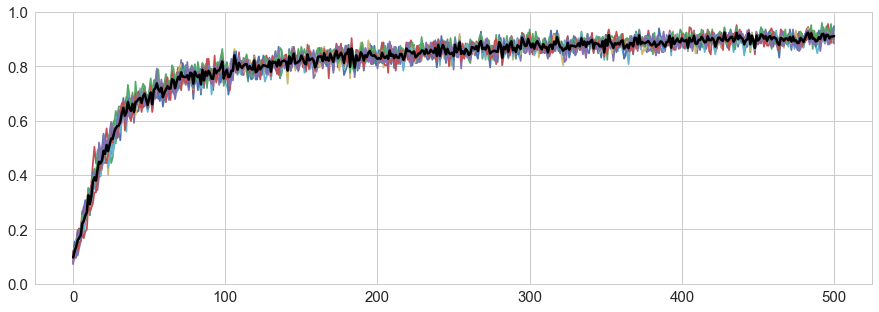

In [93]:
pd.DataFrame(progress).plot(figsize=(15,5), legend=False, ylim=[0,1])
pd.DataFrame(progress).mean(axis=1).plot(legend=False, lw=2.5, color='black')